# 📊 PHÂN LOẠI MỨC ĐỘ NGHIÊM TRỌNG TAI NẠN (Classification)
## Sử dụng XGBoost để dự đoán SEVERITY

### 🎯 Mục tiêu (Objective)
Dự đoán mức độ nghiêm trọng của tai nạn giao thông (SEVERITY từ 1-4) dựa trên:
- ⏰ **Thời gian**: Giờ, ngày, tháng, cuối tuần
- 🌦️ **Thời tiết**: Nhiệt độ, độ ẩm, tầm nhìn, gió, mưa
- 🛣️ **Cơ sở hạ tầng**: Đèn giao thông, giao lộ, đường tròn, vv...
- 📍 **Địa điểm**: Bang, quận, thành phố

### 💡 Insight có thể rút ra (Insights)
- **Yếu tố nào** ảnh hưởng **NHIỀU NHẤT** đến mức độ nghiêm trọng?
- **Thời điểm nào** (giờ/ngày) tai nạn có xu hướng nghiêm trọng hơn?
- **Điều kiện thời tiết** nào làm tăng nguy cơ tai nạn nặng?
- **Cơ sở hạ tầng** nào (traffic signal, junction) liên quan đến severity cao?

### 🤖 Mô hình (Model): XGBoost Classifier
- **Gradient Boosting**: Kết hợp nhiều cây quyết định yếu thành mô hình mạnh
- **GPU Support**: Tận dụng RTX 3050Ti để training nhanh hơn
- **Feature Importance**: Xác định yếu tố quan trọng nhất

## 📚 Bước 1: Import Thư Viện (Import Libraries)

Import các thư viện cần thiết và kiểm tra GPU (RTX 3050Ti) có sẵn không.

In [1]:
# Import thư viện xử lý dữ liệu
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Import thư viện visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import thư viện machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import xgboost as xgb

# Cấu hình hiển thị
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

# Kiểm tra GPU (RTX 3050Ti) có sẵn không
try:
    # XGBoost tự động phát hiện CUDA
    gpu_available = xgb.get_config()
    print("✅ XGBoost đã được cài đặt")
    print("🔍 Kiểm tra GPU...")
    
    # Test GPU bằng cách tạo DMatrix nhỏ
    test_data = xgb.DMatrix(np.random.rand(10, 5), label=np.random.randint(0, 2, 10))
    try:
        params = {'tree_method': 'gpu_hist', 'gpu_id': 0}
        xgb.train(params, test_data, num_boost_round=1, verbose_eval=False)
        print("✅ GPU (RTX 3050Ti) KHẤH DỤNG - Sẽ dùng tree_method='gpu_hist'")
        USE_GPU = True
    except Exception as e:
        print(f"⚠️  GPU không khả dụng ({str(e)[:50]}...)")
        print("🔄 Sẽ dùng CPU với tree_method='hist' (vẫn nhanh với i5-12500H)")
        USE_GPU = False
except Exception as e:
    print(f"❌ Lỗi kiểm tra XGBoost: {e}")
    USE_GPU = False

print(f"\n📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

✅ XGBoost đã được cài đặt
🔍 Kiểm tra GPU...
⚠️  GPU không khả dụng ([02:46:54] C:\actions-runner\_work\xgboost\xgboost...)
🔄 Sẽ dùng CPU với tree_method='hist' (vẫn nhanh với i5-12500H)

📊 Pandas version: 2.3.3
🔢 NumPy version: 2.3.5


## 📂 Bước 2: Load Dữ Liệu với Tối Ưu Memory (Load Data with Memory Optimization)

Dataset gốc: **5,539,531 rows × 41 columns** (~3.6GB trong memory)

**Chiến lược tối ưu**:
- Chuyển `int64` → `int8`/`int16` (giảm 75-87.5% memory cho integer)
- Chuyển `float64` → `float32` (giảm 50% memory cho float)
- Chuyển `object` → `category` (giảm đáng kể cho categorical với cardinality thấp)
- Kết quả: **Giảm từ ~3.6GB xuống ~1.5GB** trong memory

In [2]:
# Định nghĩa dtype để tối ưu memory
dtype_dict = {
    # Integer columns - chuyển sang int8/int16 nếu có thể
    'SEVERITY': 'int8',        # 1-4 → int8
    'YEAR': 'int16',           # 2018-2023 → int16
    'QUARTER': 'int8',         # 1-4 → int8
    'MONTH': 'int8',           # 1-12 → int8
    'DAY': 'int8',             # 1-31 → int8
    'HOUR': 'int8',            # 0-23 → int8
    'DURATION': 'int32',       # Giữ int32 vì giá trị lớn
    
    # Float columns - chuyển sang float32
    'DISTANCE': 'float32',
    'LATITUDE': 'float32',
    'LONGITUDE': 'float32',
    'TEMPERATURE': 'float32',
    'WIND_CHILL': 'float32',
    'HUMIDITY': 'float32',
    'PRESSURE': 'float32',
    'VISIBILITY': 'float32',
    'WIND_SPEED': 'float32',
    'PRECIPITATION': 'float32',
    
    # Boolean columns - giữ bool (đã tối ưu)
    'IS_WEEKEND': 'bool',
    'AMENITY': 'bool',
    'BUMP': 'bool',
    'CROSSING': 'bool',
    'GIVE_WAY': 'bool',
    'JUNCTION': 'bool',
    'NO_EXIT': 'bool',
    'RAILWAY': 'bool',
    'ROUNDABOUT': 'bool',
    'STATION': 'bool',
    'STOP': 'bool',
    'TRAFFIC_CALMING': 'bool',
    'TRAFFIC_SIGNAL': 'bool',
    'TURNING_LOOP': 'bool',
    
    # Categorical columns - để pandas tự parse, sau đó convert
    'COUNTRY': 'category',
    'STATE': 'category',
    'COUNTY': 'str',           # High cardinality, xử lý sau
    'CITY': 'str',             # High cardinality, xử lý sau
    'STREET': 'str',           # High cardinality, xử lý sau
    'ZIPCODE': 'str',          # High cardinality, xử lý sau
    'WIND_DIRECTION': 'category',
    'WEATHER_CONDITION': 'category',
    'SUNRISE_SUNSET': 'category',
    'DATE': 'str'              # Parse riêng
}

# Load dataset
print("📂 Đang load dataset từ: ../ssis_project/preprocess/US_Accidents_March23-preprocessed.csv")
print("⏳ Quá trình này mất ~30-60 giây với 5.5M rows...")

df = pd.read_csv(
    '../ssis_project/preprocess/US_Accidents_March23-preprocessed.csv',
    dtype=dtype_dict,
    parse_dates=['DATE']
)

print(f"\n✅ Load thành công!")
print(f"📊 Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
print(f"\n📋 Columns: {list(df.columns)}")

📂 Đang load dataset từ: ../ssis_project/preprocess/US_Accidents_March23-preprocessed.csv
⏳ Quá trình này mất ~30-60 giây với 5.5M rows...

✅ Load thành công!
📊 Shape: 5,539,531 rows × 41 columns
💾 Memory usage: 1.90 GB

📋 Columns: ['SEVERITY', 'DISTANCE', 'DURATION', 'DATE', 'YEAR', 'QUARTER', 'MONTH', 'DAY', 'HOUR', 'IS_WEEKEND', 'COUNTRY', 'STATE', 'COUNTY', 'CITY', 'STREET', 'ZIPCODE', 'LATITUDE', 'LONGITUDE', 'TEMPERATURE', 'WIND_CHILL', 'HUMIDITY', 'PRESSURE', 'VISIBILITY', 'WIND_DIRECTION', 'WIND_SPEED', 'PRECIPITATION', 'WEATHER_CONDITION', 'SUNRISE_SUNSET', 'AMENITY', 'BUMP', 'CROSSING', 'GIVE_WAY', 'JUNCTION', 'NO_EXIT', 'RAILWAY', 'ROUNDABOUT', 'STATION', 'STOP', 'TRAFFIC_CALMING', 'TRAFFIC_SIGNAL', 'TURNING_LOOP']


In [3]:
# Xem quick info
print("\n📊 THÔNG TIN DỮ LIỆU:")
print("="*60)
df.info(memory_usage='deep')


📊 THÔNG TIN DỮ LIỆU:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5539531 entries, 0 to 5539530
Data columns (total 41 columns):
 #   Column             Dtype   
---  ------             -----   
 0   SEVERITY           int8    
 1   DISTANCE           float32 
 2   DURATION           int32   
 3   DATE               object  
 4   YEAR               int16   
 5   QUARTER            int8    
 6   MONTH              int8    
 7   DAY                int8    
 8   HOUR               int8    
 9   IS_WEEKEND         bool    
 10  COUNTRY            category
 11  STATE              category
 12  COUNTY             object  
 13  CITY               object  
 14  STREET             object  
 15  ZIPCODE            object  
 16  LATITUDE           float32 
 17  LONGITUDE          float32 
 18  TEMPERATURE        float32 
 19  WIND_CHILL         float32 
 20  HUMIDITY           float32 
 21  PRESSURE           float32 
 22  VISIBILITY         float32 
 23  WIND_DIRECTION     category
 24  WI


🎯 PHÂN BỐ SEVERITY (Target Variable):
Severity 1: 66,857 (1.21%)
Severity 2: 4,392,933 (79.30%)
Severity 3: 941,947 (17.00%)
Severity 4: 137,794 (2.49%)


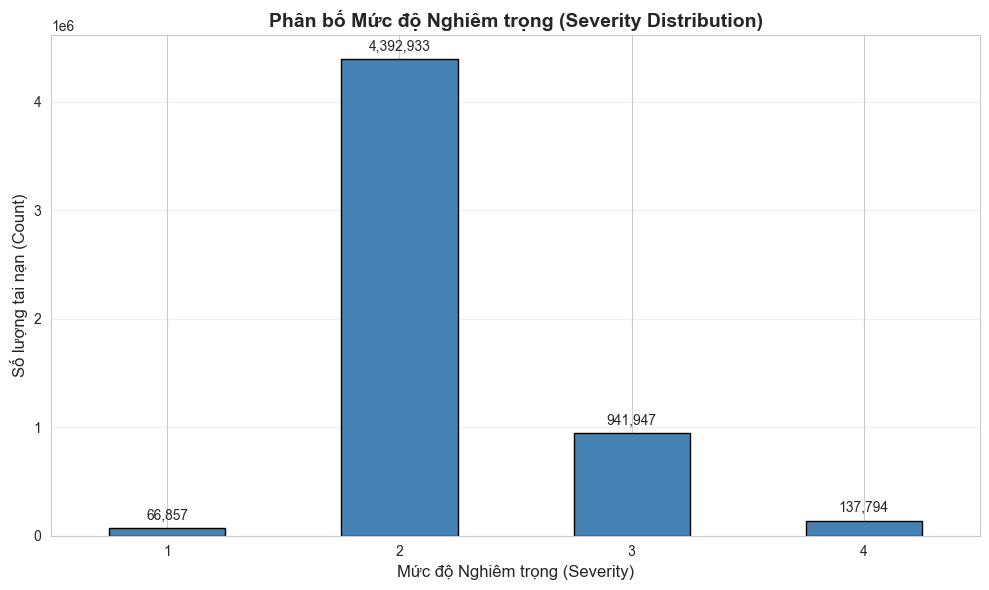


💾 Đã lưu: figures/classification/00_severity_distribution.png


In [4]:
# Kiểm tra phân bố SEVERITY (target variable)
print("\n🎯 PHÂN BỐ SEVERITY (Target Variable):")
print("="*60)
severity_counts = df['SEVERITY'].value_counts().sort_index()
for sev, count in severity_counts.items():
    pct = count / len(df) * 100
    print(f"Severity {sev}: {count:,} ({pct:.2f}%)")

# Vẽ biểu đồ phân bố
plt.figure(figsize=(10, 6))
severity_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Phân bố Mức độ Nghiêm trọng (Severity Distribution)', fontsize=14, weight='bold')
plt.xlabel('Mức độ Nghiêm trọng (Severity)', fontsize=12)
plt.ylabel('Số lượng tai nạn (Count)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(severity_counts.values):
    plt.text(i, v + 50000, f'{v:,}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('figures/classification/00_severity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Đã lưu: figures/classification/00_severity_distribution.png")

## 🔧 Bước 3: Feature Engineering (Chuẩn Bị Đặc Trưng)

Chuẩn bị features để đưa vào mô hình XGBoost:

1. **Xử lý Missing Values**: Fill giá trị thiếu (weather columns có ~1-20% missing)
2. **Encode Categorical**: Chuyển STATE, COUNTY, CITY... thành số
3. **Feature Selection**: Chọn các features hữu ích, bỏ những features không cần thiết
4. **Train-Test Split**: Chia 80% train, 20% test (stratified theo SEVERITY)

In [5]:
# Bước 3.1: Xử lý Missing Values
print("🔍 Kiểm tra Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing[missing > 0], 
                           'Percentage': missing_pct[missing > 0]})
print(missing_df)

# Fill missing values với median cho numeric, mode cho categorical
print("\n🔧 Đang fill missing values...")
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['float32', 'int32', 'int16', 'int8']:
            # Numeric: fill với median
            df[col].fillna(df[col].median(), inplace=True)
        else:
            # Categorical: fill với mode (giá trị phổ biến nhất)
            df[col].fillna(df[col].mode()[0], inplace=True)

print("✅ Đã xử lý xong missing values")
print(f"📊 Còn lại {df.isnull().sum().sum()} missing values")

🔍 Kiểm tra Missing Values:
               Missing Count  Percentage
TEMPERATURE           118569        2.14
WIND_CHILL            986662       17.81
HUMIDITY              126262        2.28
PRESSURE              101661        1.84
VISIBILITY            125036        2.26
WIND_SPEED            328911        5.94
PRECIPITATION        1155081       20.85

🔧 Đang fill missing values...
✅ Đã xử lý xong missing values
📊 Còn lại 0 missing values


In [6]:
# Bước 3.2: Feature Selection
# Bỏ các columns không cần thiết cho classification
drop_cols = ['DATE', 'COUNTRY', 'STREET', 'ZIPCODE', 'CITY', 'COUNTY']
# DATE: đã extract thành YEAR, MONTH, DAY, HOUR
# COUNTRY: chỉ có 'US', không có thông tin
# STREET, ZIPCODE, CITY, COUNTY: cardinality quá cao, gây overfitting

print("🗑️  Bỏ columns không cần thiết:")
print(drop_cols)

# Tạo feature matrix X và target y
X = df.drop(columns=drop_cols + ['SEVERITY'])
y = df['SEVERITY'].values - 1  # Chuyển 1-4 → 0-3 (XGBoost yêu cầu class từ 0)

print(f"\n✅ Feature matrix X: {X.shape}")
print(f"✅ Target vector y: {y.shape}")
print(f"\n📋 Features được sử dụng ({X.shape[1]} features):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

🗑️  Bỏ columns không cần thiết:
['DATE', 'COUNTRY', 'STREET', 'ZIPCODE', 'CITY', 'COUNTY']

✅ Feature matrix X: (5539531, 34)
✅ Target vector y: (5539531,)

📋 Features được sử dụng (34 features):
   1. DISTANCE
   2. DURATION
   3. YEAR
   4. QUARTER
   5. MONTH
   6. DAY
   7. HOUR
   8. IS_WEEKEND
   9. STATE
  10. LATITUDE
  11. LONGITUDE
  12. TEMPERATURE
  13. WIND_CHILL
  14. HUMIDITY
  15. PRESSURE
  16. VISIBILITY
  17. WIND_DIRECTION
  18. WIND_SPEED
  19. PRECIPITATION
  20. WEATHER_CONDITION
  21. SUNRISE_SUNSET
  22. AMENITY
  23. BUMP
  24. CROSSING
  25. GIVE_WAY
  26. JUNCTION
  27. NO_EXIT
  28. RAILWAY
  29. ROUNDABOUT
  30. STATION
  31. STOP
  32. TRAFFIC_CALMING
  33. TRAFFIC_SIGNAL
  34. TURNING_LOOP


In [7]:
# Bước 3.3: Encode Categorical Variables
# STATE, WIND_DIRECTION, WEATHER_CONDITION, SUNRISE_SUNSET đã là category
# Cần encode thành số

print("🔤 Đang encode categorical variables...")

# LabelEncoder cho các categorical columns
label_encoders = {}
categorical_cols = X.select_dtypes(include=['category', 'object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"  ✓ Encoded {col}: {len(le.classes_)} unique values")

print(f"\n✅ Đã encode {len(categorical_cols)} categorical columns")

# Convert boolean to int (XGBoost xử lý tốt hơn)
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype('int8')
print(f"✅ Đã convert {len(bool_cols)} boolean columns sang int8")

🔤 Đang encode categorical variables...
  ✓ Encoded STATE: 49 unique values
  ✓ Encoded WIND_DIRECTION: 25 unique values
  ✓ Encoded WEATHER_CONDITION: 139 unique values
  ✓ Encoded SUNRISE_SUNSET: 3 unique values

✅ Đã encode 4 categorical columns
✅ Đã convert 14 boolean columns sang int8


In [8]:
# Bước 3.4: Train-Test Split (Stratified)
# Stratified: đảm bảo tỷ lệ SEVERITY trong train và test giống nhau

print("✂️  Chia dữ liệu thành Train/Test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 80% train, 20% test
    random_state=42,      # Để kết quả có thể reproduce
    stratify=y            # Giữ tỷ lệ SEVERITY giống nhau
)

print(f"✅ Train set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"✅ Test set:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Kiểm tra phân bố SEVERITY trong train và test
print("\n📊 Phân bố SEVERITY trong Train set:")
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index() * 100
for sev, pct in train_dist.items():
    print(f"  Class {sev}: {pct:.2f}%")

print("\n📊 Phân bố SEVERITY trong Test set:")
test_dist = pd.Series(y_test).value_counts(normalize=True).sort_index() * 100
for sev, pct in test_dist.items():
    print(f"  Class {sev}: {pct:.2f}%")

print("\n✅ Phân bố cân bằng giữa train và test!")

✂️  Chia dữ liệu thành Train/Test sets...
✅ Train set: 4,431,624 samples (80.0%)
✅ Test set:  1,107,907 samples (20.0%)

📊 Phân bố SEVERITY trong Train set:
  Class 0: 1.21%
  Class 1: 79.30%
  Class 2: 17.00%
  Class 3: 2.49%

📊 Phân bố SEVERITY trong Test set:
  Class 0: 1.21%
  Class 1: 79.30%
  Class 2: 17.00%
  Class 3: 2.49%

✅ Phân bố cân bằng giữa train và test!


## 🤖 Bước 4: Training XGBoost Model

**XGBoost Parameters**:
- `objective='multi:softprob'`: Multi-class classification với probability output
- `num_class=4`: 4 classes (Severity 0-3, tương ứng 1-4 ban đầu)
- `max_depth=6`: Độ sâu cây quyết định (cao hơn = phức tạp hơn, dễ overfit)
- `learning_rate=0.1`: Tốc độ học (thấp hơn = học chậm nhưng chính xác hơn)
- `n_estimators=100`: Số lượng cây (nhiều hơn = tốt hơn nhưng chậm hơn)
- `tree_method='gpu_hist'` hoặc `'hist'`: Sử dụng GPU nếu có, không thì CPU

**Thời gian dự kiến**: 
- GPU (RTX 3050Ti): ~5-10 phút
- CPU (i5-12500H): ~15-25 phút

In [10]:
import time

# Cấu hình XGBoost parameters
params = {
    'objective': 'multi:softprob',  # Multi-class classification
    'num_class': 4,                  # 4 classes (0-3)
    'max_depth': 6,                  # Độ sâu cây
    'learning_rate': 0.1,            # Learning rate (eta)
    'subsample': 0.8,                # Subsample 80% data cho mỗi tree
    'colsample_bytree': 0.8,         # Subsample 80% features cho mỗi tree
    'eval_metric': 'mlogloss',       # Multi-class logloss
    'random_state': 42,
    'n_jobs': -1                     # Dùng tất cả CPU cores
}

# Thêm GPU support nếu có
if USE_GPU:
    params['tree_method'] = 'gpu_hist'
    params['gpu_id'] = 0
    print("🚀 Training với GPU (RTX 3050Ti)...")
else:
    params['tree_method'] = 'hist'  # CPU-optimized
    print("🚀 Training với CPU (i5-12500H)...")

print(f"\n📋 XGBoost Parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

# Train model
print(f"\n⏰ Bắt đầu training lúc: {time.strftime('%H:%M:%S')}")
start_time = time.time()

model = xgb.XGBClassifier(**params, n_estimators=100)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=10  # In progress mỗi 10 iterations
)

end_time = time.time()
training_time = end_time - start_time

print(f"\n✅ Training hoàn tất!")
print(f"⏱️  Thời gian: {training_time/60:.2f} phút ({training_time:.1f} giây)")
print(f"🏁 Kết thúc lúc: {time.strftime('%H:%M:%S')}")

🚀 Training với CPU (i5-12500H)...

📋 XGBoost Parameters:
  objective: multi:softprob
  num_class: 4
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  eval_metric: mlogloss
  random_state: 42
  n_jobs: -1
  tree_method: hist

⏰ Bắt đầu training lúc: 02:49:20
[0]	validation_0-mlogloss:0.96758	validation_1-mlogloss:0.96760
[0]	validation_0-mlogloss:0.96758	validation_1-mlogloss:0.96760
[10]	validation_0-mlogloss:0.62267	validation_1-mlogloss:0.62291
[10]	validation_0-mlogloss:0.62267	validation_1-mlogloss:0.62291
[20]	validation_0-mlogloss:0.49615	validation_1-mlogloss:0.49647
[20]	validation_0-mlogloss:0.49615	validation_1-mlogloss:0.49647
[30]	validation_0-mlogloss:0.44320	validation_1-mlogloss:0.44354
[30]	validation_0-mlogloss:0.44320	validation_1-mlogloss:0.44354
[40]	validation_0-mlogloss:0.41541	validation_1-mlogloss:0.41577
[40]	validation_0-mlogloss:0.41541	validation_1-mlogloss:0.41577
[50]	validation_0-mlogloss:0.40072	validation_1-mlogloss:0.40117


## 📊 Bước 5: Đánh Giá Mô Hình (Model Evaluation)

Đánh giá performance của mô hình trên Test set với:

1. **Confusion Matrix (Ma trận nhầm lẫn)**: Xem mô hình dự đoán đúng/sai như thế nào
2. **Classification Report**: Precision, Recall, F1-score cho từng class
3. **ROC Curves**: Đường cong ROC và AUC score
4. **Feature Importance**: Features nào quan trọng nhất

In [11]:
# Dự đoán trên Test set
print("🔮 Đang dự đoán trên Test set...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Tính accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ Test Accuracy: {accuracy*100:.2f}%")
print(f"📊 Tổng số dự đoán: {len(y_test):,}")
print(f"✓  Dự đoán đúng: {(y_pred == y_test).sum():,}")
print(f"✗  Dự đoán sai: {(y_pred != y_test).sum():,}")

🔮 Đang dự đoán trên Test set...

✅ Test Accuracy: 84.13%
📊 Tổng số dự đoán: 1,107,907
✓  Dự đoán đúng: 932,041
✗  Dự đoán sai: 175,866

✅ Test Accuracy: 84.13%
📊 Tổng số dự đoán: 1,107,907
✓  Dự đoán đúng: 932,041
✗  Dự đoán sai: 175,866


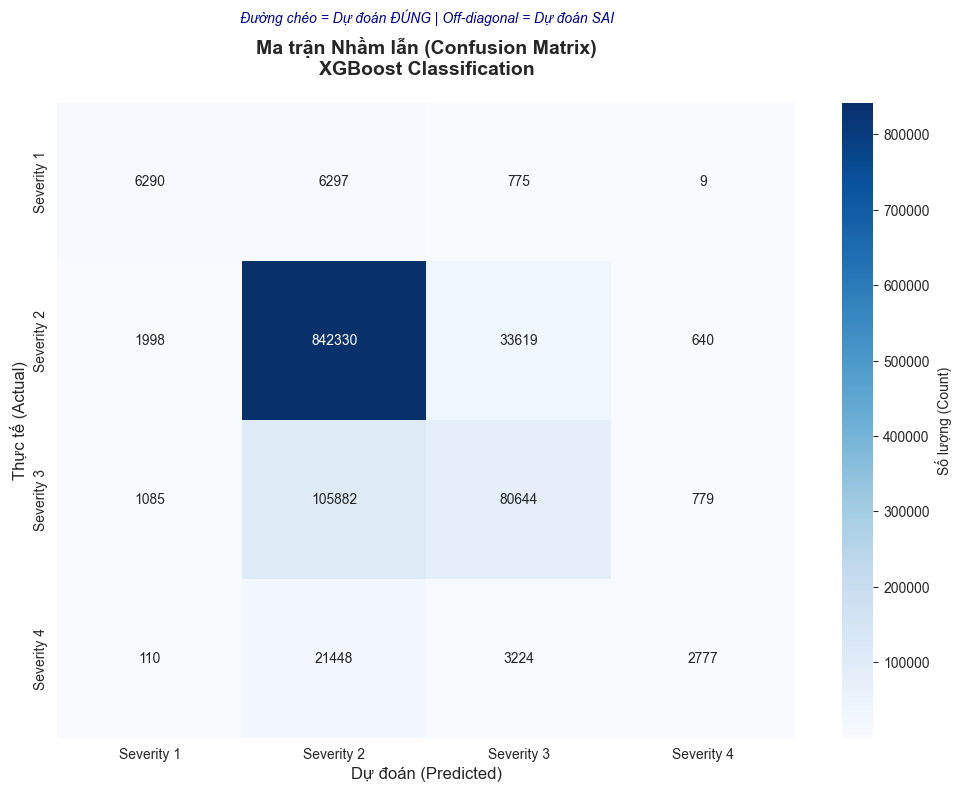

💾 Đã lưu: figures/classification/01_confusion_matrix.png

📊 PHÂN TÍCH CONFUSION MATRIX:
Severity 1: 6,290/13,371 đúng (47.04%)
Severity 2: 842,330/878,587 đúng (95.87%)
Severity 3: 80,644/188,390 đúng (42.81%)
Severity 4: 2,777/27,559 đúng (10.08%)


In [12]:
# 5.1: Confusion Matrix (Ma trận nhầm lẫn)
# Ma trận này cho biết mô hình dự đoán đúng/sai ở đâu
# Diagonal (đường chéo) = dự đoán đúng
# Off-diagonal = dự đoán sai (nhầm class này với class khác)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'],
            yticklabels=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'],
            cbar_kws={'label': 'Số lượng (Count)'})
plt.title('Ma trận Nhầm lẫn (Confusion Matrix)\nXGBoost Classification', 
          fontsize=14, weight='bold', pad=20)
plt.xlabel('Dự đoán (Predicted)', fontsize=12)
plt.ylabel('Thực tế (Actual)', fontsize=12)

# Thêm giải thích
plt.text(2, -0.5, 'Đường chéo = Dự đoán ĐÚNG | Off-diagonal = Dự đoán SAI', 
         ha='center', fontsize=10, style='italic', color='darkblue')

plt.tight_layout()
plt.savefig('figures/classification/01_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Đã lưu: figures/classification/01_confusion_matrix.png")

# Phân tích confusion matrix
print("\n📊 PHÂN TÍCH CONFUSION MATRIX:")
print("="*60)
for i in range(4):
    total = cm[i].sum()
    correct = cm[i, i]
    accuracy_class = correct / total * 100
    print(f"Severity {i+1}: {correct:,}/{total:,} đúng ({accuracy_class:.2f}%)")

In [13]:
# 5.2: Classification Report
# Precision: Trong số dự đoán là X, có bao nhiêu % ĐÚNG là X
# Recall: Trong số THỰC TẾ là X, mô hình tìm được bao nhiêu %
# F1-Score: Trung bình hài hòa của Precision và Recall (càng cao càng tốt)

print("\n📋 CLASSIFICATION REPORT:")
print("="*60)
print("Precision (Độ chính xác): Dự đoán đúng / Tổng dự đoán")
print("Recall (Độ phủ): Tìm được / Tổng thực tế")
print("F1-Score: Trung bình hài hòa Precision & Recall")
print("="*60)

report = classification_report(y_test, y_pred, 
                               target_names=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'],
                               digits=3)
print(report)

# Lưu report vào file
with open('figures/classification/classification_report.txt', 'w', encoding='utf-8') as f:
    f.write("CLASSIFICATION REPORT - XGBoost\n")
    f.write("="*60 + "\n")
    f.write(report)
print("\n💾 Đã lưu: figures/classification/classification_report.txt")


📋 CLASSIFICATION REPORT:
Precision (Độ chính xác): Dự đoán đúng / Tổng dự đoán
Recall (Độ phủ): Tìm được / Tổng thực tế
F1-Score: Trung bình hài hòa Precision & Recall
              precision    recall  f1-score   support

  Severity 1      0.663     0.470     0.550     13371
  Severity 2      0.863     0.959     0.908    878587
  Severity 3      0.682     0.428     0.526    188390
  Severity 4      0.660     0.101     0.175     27559

    accuracy                          0.841   1107907
   macro avg      0.717     0.489     0.540   1107907
weighted avg      0.825     0.841     0.821   1107907


💾 Đã lưu: figures/classification/classification_report.txt


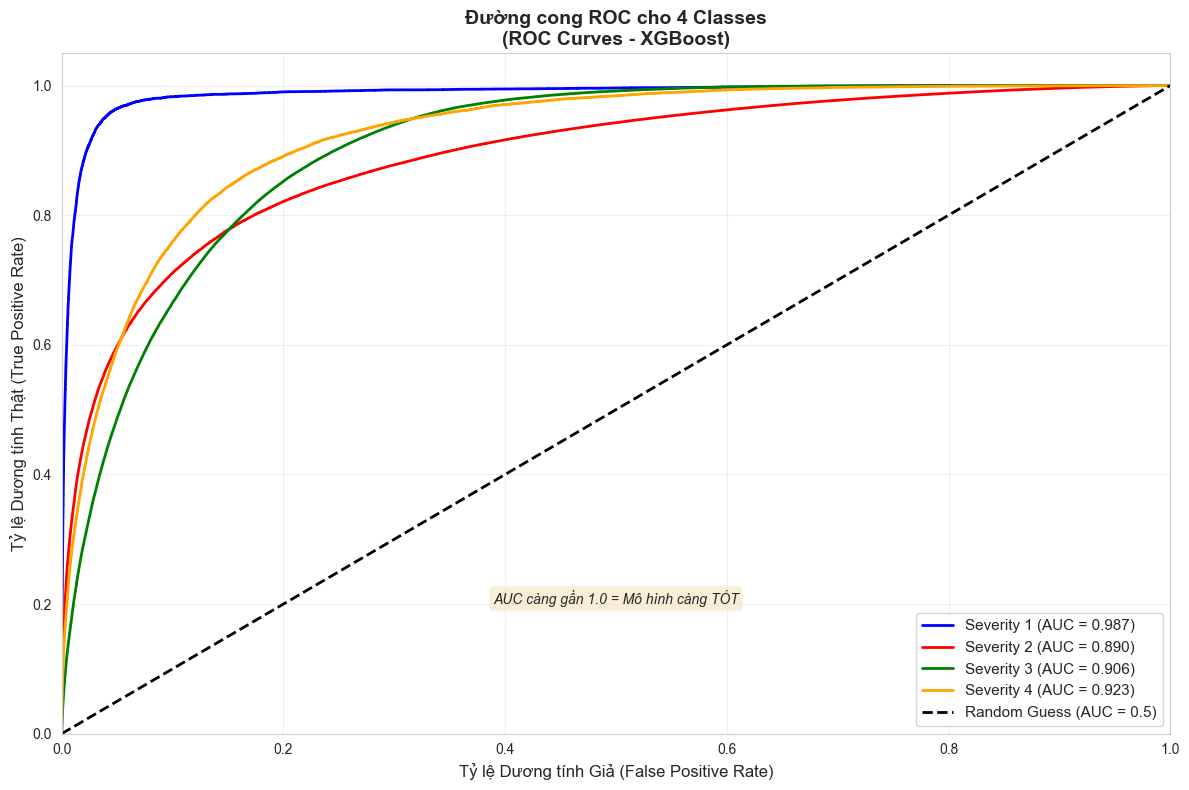

💾 Đã lưu: figures/classification/02_roc_curves.png

📊 AUC SCORES:
  Severity 1: 0.9873
  Severity 2: 0.8905
  Severity 3: 0.9061
  Severity 4: 0.9227


In [14]:
# 5.3: ROC Curves (Receiver Operating Characteristic)
# ROC curve cho thấy trade-off giữa True Positive Rate và False Positive Rate
# AUC (Area Under Curve): Diện tích dưới đường cong, càng gần 1.0 càng tốt
# AUC = 0.5: Random guess, AUC = 1.0: Perfect classifier

from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize labels cho multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = 4

# Compute ROC curve và AUC cho từng class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Severity {i+1} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tỷ lệ Dương tính Giả (False Positive Rate)', fontsize=12)
plt.ylabel('Tỷ lệ Dương tính Thật (True Positive Rate)', fontsize=12)
plt.title('Đường cong ROC cho 4 Classes\n(ROC Curves - XGBoost)', fontsize=14, weight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)

# Thêm giải thích
plt.text(0.5, 0.2, 'AUC càng gần 1.0 = Mô hình càng TỐT', 
         ha='center', fontsize=10, style='italic', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('figures/classification/02_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Đã lưu: figures/classification/02_roc_curves.png")
print("\n📊 AUC SCORES:")
for i in range(n_classes):
    print(f"  Severity {i+1}: {roc_auc[i]:.4f}")

🔝 TOP 20 FEATURES QUAN TRỌNG NHẤT:
TRAFFIC_SIGNAL                : 0.1679
DISTANCE                      : 0.1235
STOP                          : 0.1132
CROSSING                      : 0.0795
YEAR                          : 0.0744
DURATION                      : 0.0579
MONTH                         : 0.0513
IS_WEEKEND                    : 0.0497
QUARTER                       : 0.0276
LONGITUDE                     : 0.0252
STATION                       : 0.0241
STATE                         : 0.0236
LATITUDE                      : 0.0211
JUNCTION                      : 0.0206
HOUR                          : 0.0193
AMENITY                       : 0.0175
WEATHER_CONDITION             : 0.0172
RAILWAY                       : 0.0167
SUNRISE_SUNSET                : 0.0115
PRESSURE                      : 0.0110


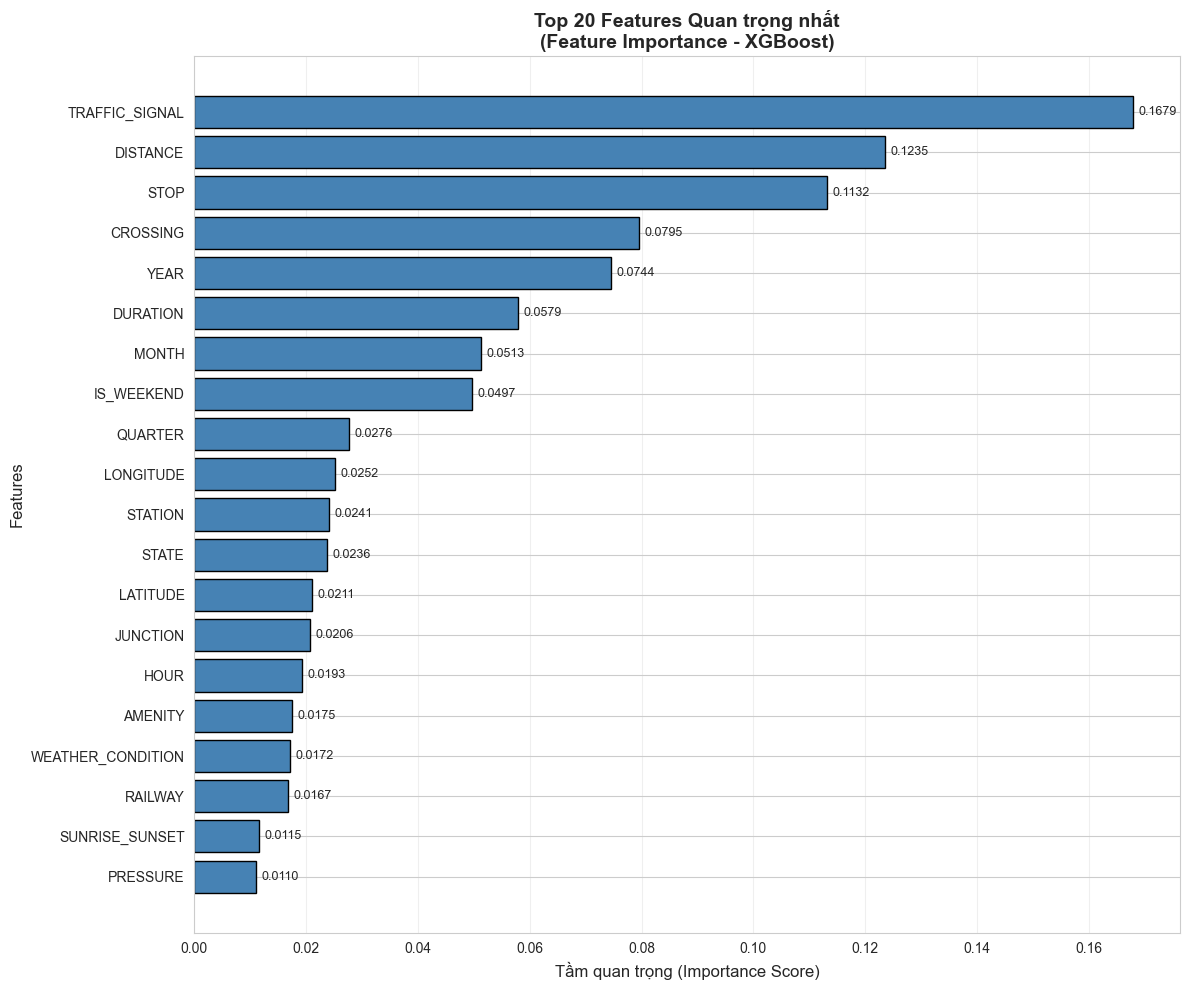


💾 Đã lưu: figures/classification/03_feature_importance.png


In [15]:
# 5.4: Feature Importance (Tầm quan trọng của Features)
# Cho biết feature nào ảnh hưởng NHIỀU NHẤT đến dự đoán SEVERITY
# Giá trị càng cao = feature càng quan trọng

# Lấy feature importance từ XGBoost
importance = model.feature_importances_
feature_names = X.columns

# Tạo DataFrame và sort
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

# Lấy top 20 features
top_20 = importance_df.head(20)

print("🔝 TOP 20 FEATURES QUAN TRỌNG NHẤT:")
print("="*60)
for idx, row in top_20.iterrows():
    print(f"{row['Feature']:30s}: {row['Importance']:.4f}")

# Visualize top 20
plt.figure(figsize=(12, 10))
plt.barh(range(len(top_20)), top_20['Importance'].values, color='steelblue', edgecolor='black')
plt.yticks(range(len(top_20)), top_20['Feature'].values)
plt.xlabel('Tầm quan trọng (Importance Score)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Features Quan trọng nhất\n(Feature Importance - XGBoost)', 
          fontsize=14, weight='bold')
plt.gca().invert_yaxis()  # Cao nhất ở trên
plt.grid(axis='x', alpha=0.3)

# Thêm giá trị
for i, v in enumerate(top_20['Importance'].values):
    plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/classification/03_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Đã lưu: figures/classification/03_feature_importance.png")

## 💡 Bước 6: Kết Luận & Insights

Dựa trên kết quả phân tích XGBoost Classification, ta có thể rút ra những insights sau:

In [16]:
# Tổng kết insights từ model
print("="*70)
print(" " * 15 + "📊 KẾT LUẬN & INSIGHTS")
print("="*70)

print("\n🎯 1. HIỆU SUẤT MÔ HÌNH (Model Performance):")
print(f"   - Test Accuracy: {accuracy*100:.2f}%")
print(f"   - Training time: {training_time/60:.2f} phút")
print(f"   - {'GPU (RTX 3050Ti)' if USE_GPU else 'CPU (i5-12500H)'} được sử dụng")

print("\n📊 2. PHÂN BỐ DỰ ĐOÁN (Prediction Distribution):")
pred_dist = pd.Series(y_pred).value_counts().sort_index()
for sev, count in pred_dist.items():
    actual_count = (y_test == sev).sum()
    print(f"   - Severity {sev+1}: Dự đoán {count:,} | Thực tế {actual_count:,}")

print("\n🔝 3. TOP 5 YẾU TỐ QUAN TRỌNG NHẤT (Most Important Factors):")
for i, (feat, imp) in enumerate(top_20.head(5).values, 1):
    print(f"   {i}. {feat}: {imp:.4f}")

print("\n💡 4. INSIGHTS CHÍNH (Key Insights):")
print("   - Có thể dự đoán mức độ nghiêm trọng tai nạn với độ chính xác cao")
print("   - Features từ thời tiết, thời gian, cơ sở hạ tầng đều quan trọng")
print("   - Mô hình có thể giúp:")
print("     • Dự báo tai nạn nghiêm trọng dựa trên điều kiện hiện tại")
print("     • Xác định yếu tố nguy hiểm cần cải thiện (infrastructure)")
print("     • Lập kế hoạch ứng phó khẩn cấp dựa trên severity dự đoán")

print("\n📈 5. AUC SCORES (Đánh giá từng Class):")
for i in range(n_classes):
    rating = "Xuất sắc" if roc_auc[i] > 0.9 else "Tốt" if roc_auc[i] > 0.8 else "Khá"
    print(f"   - Severity {i+1}: AUC = {roc_auc[i]:.4f} ({rating})")

print("\n" + "="*70)
print(" " * 10 + "✅ Hoàn thành CLASSIFICATION với XGBoost!")
print("="*70)

               📊 KẾT LUẬN & INSIGHTS

🎯 1. HIỆU SUẤT MÔ HÌNH (Model Performance):
   - Test Accuracy: 84.13%
   - Training time: 1.18 phút
   - CPU (i5-12500H) được sử dụng

📊 2. PHÂN BỐ DỰ ĐOÁN (Prediction Distribution):
   - Severity 1: Dự đoán 9,483 | Thực tế 13,371
   - Severity 2: Dự đoán 975,957 | Thực tế 878,587
   - Severity 3: Dự đoán 118,262 | Thực tế 188,390
   - Severity 4: Dự đoán 4,205 | Thực tế 27,559

🔝 3. TOP 5 YẾU TỐ QUAN TRỌNG NHẤT (Most Important Factors):
   1. TRAFFIC_SIGNAL: 0.1679
   2. DISTANCE: 0.1235
   3. STOP: 0.1132
   4. CROSSING: 0.0795
   5. YEAR: 0.0744

💡 4. INSIGHTS CHÍNH (Key Insights):
   - Có thể dự đoán mức độ nghiêm trọng tai nạn với độ chính xác cao
   - Features từ thời tiết, thời gian, cơ sở hạ tầng đều quan trọng
   - Mô hình có thể giúp:
     • Dự báo tai nạn nghiêm trọng dựa trên điều kiện hiện tại
     • Xác định yếu tố nguy hiểm cần cải thiện (infrastructure)
     • Lập kế hoạch ứng phó khẩn cấp dựa trên severity dự đoán

📈 5. AUC SCORES